In [8]:
import zombie_imp
import csv
import serial
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import pywt
import numpy as np
from scipy import stats
import statistics
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
class RingBuffer:
    def __init__(self, size):
        self.size = size
        self.data = [None] * size
        self.head = 0
        self.tail = 0
        self.count = 0

    def append(self, item):
        if self.count < self.size:
            self.data[self.tail] = item
            self.tail = (self.tail + 1) % self.size
            self.count += 1
        else:
            # If the buffer is full, overwrite the oldest data
            self.data[self.head] = item
            self.head = (self.head + 1) % self.size
            self.tail = (self.tail + 1) % self.size

    def get(self):
        return [self.data[(self.head + i) % self.size] for i in range(self.count)]
    
    def clear(self):
        self.data = [None] * self.size
        self.head = 0
        self.tail = 0
        self.count = 0

    def __len__(self):
        return self.count

## Read the data from serial port

In [31]:
# Initialize the Serial port
ser = serial.Serial('COM3', 115200)  # Change the port and baud rate according to transmitter

# create the CSV file
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Cell 1', 'Cell 2', 'Cell 3'])  

#     # read the data from port and store in CSV file
#     try:
#         while True:
#             data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
#             if data:
#                 values = data.split(' ')  # split with space
#                 if len(values) == 3:  # make sure there are three values
#                     writer.writerow([int(val) for val in values])  # store the data
#     except KeyboardInterrupt:  # stop iteration by Ctrl+C
#         pass

#for two cells
with open('sensor_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell 1', 'Cell 2'])  

    # read the data from port and store in CSV file
    try:
        while True:
            data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
            if data:
                values = data.split(' ')  # split with space
                if len(values) == 2:  # make sure there are three values
                    writer.writerow([int(val) for val in values])  # store the data
    except KeyboardInterrupt:  # stop iteration by Ctrl+C
        pass
    finally:
        ser.close()
        
# #for one cell
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Sensor Value']) 

#     try:
#         while True:
#             data = ser.readline().decode('utf-8').strip()  
#             if data:
#                 writer.writerow([int(data)])  
#     except KeyboardInterrupt:  
#         pass
#     finally:
#         ser.close()

## Load the CSV files for different gestures

In [32]:
# read the csv file
df_1 = pd.read_csv('two_cells/flat_hand.csv')
df_2 = pd.read_csv('two_cells/vertical_hand.csv')

# get the data of each solar cell
solar_cell_1_flat = df_1['Cell 1']
solar_cell_2_flat = df_1['Cell 2']
solar_cell_1_vertical = df_2['Cell 1']
solar_cell_2_vertical = df_2['Cell 2']
# solar_cell_2 = df['Cell 2']
# solar_cell_3 = df['Cell 3']

# apply DWT for the current value of each solar cell
coeffs_1_flat = pywt.wavedec(solar_cell_1_flat, 'haar', level=5) #coeffs_1[0] contains the first-level approximation coefficient of solar_cell_1, coeffs_1[1] contains the first-level detail coefficient of solar_cell_1
coeffs_2_flat = pywt.wavedec(solar_cell_2_flat, 'haar', level=5)
coeffs_1_vertical = pywt.wavedec(solar_cell_1_vertical, 'haar', level=5)
coeffs_2_vertical = pywt.wavedec(solar_cell_2_vertical, 'haar', level=5)
# coeffs_2 = pywt.wavedec(solar_cell_2, 'haar', level=5)
# coeffs_3 = pywt.wavedec(solar_cell_3, 'haar', level=5)

# cA5, cD5, cD4, cD3, cD2, cD1 = coeffs_1

# print("Coefficients for solar_cell_1:", cA5)
# print("Coefficients for solar_cell_2:", coeffs_2)
# print("Coefficients for solar_cell_3:", coeffs_3)

## Use DWT to denoise

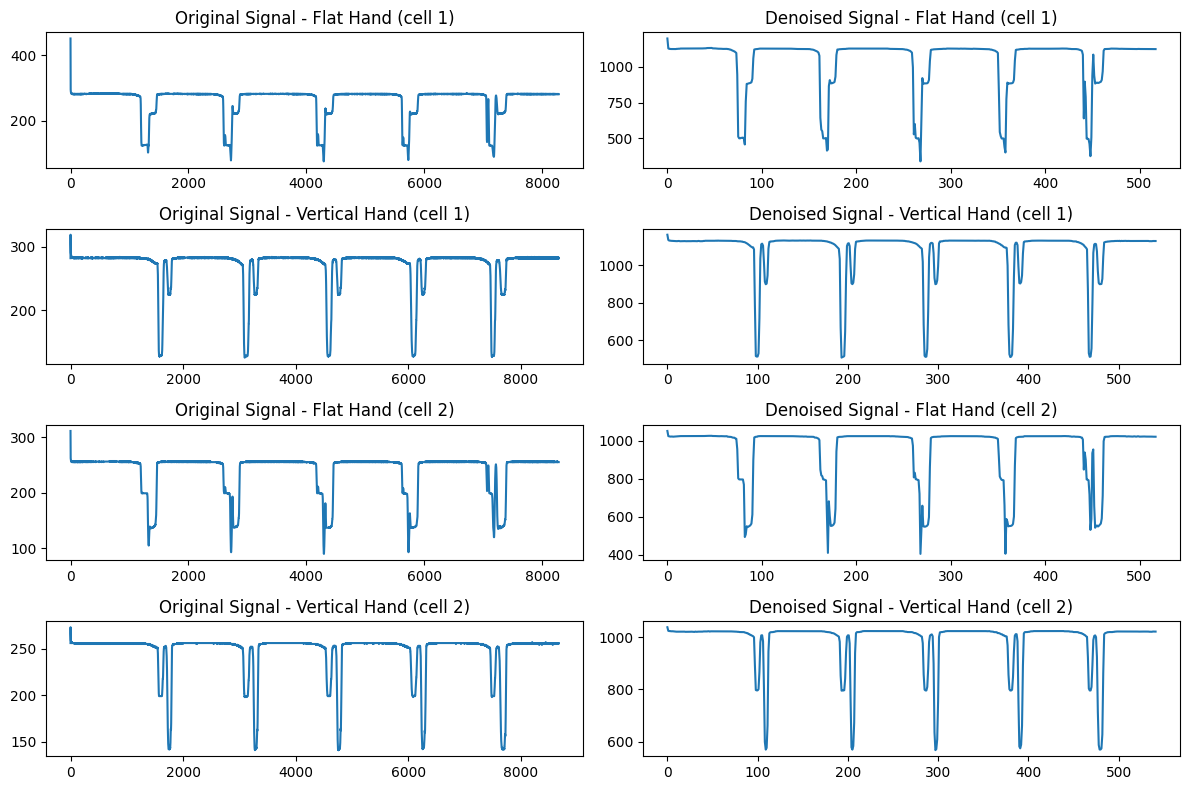

In [33]:
# should be changed based on reality
threshold = 0.4

# For cell 1
approx_coeff_1_flat = coeffs_1_flat[0]
detail_coeff_1_flat = coeffs_1_flat[1]
approx_coeff_1_vertical = coeffs_1_vertical[0]
detail_coeff_1_vertical = coeffs_1_vertical[1]

## Apply a threshold on the detail coefficient on signals of cell 1
detail_coeff_thresh_1_flat = pywt.threshold(detail_coeff_1_flat, threshold, mode='soft')
detail_coeff_thresh_1_vertical = pywt.threshold(detail_coeff_1_vertical, threshold, mode='soft')

## Reconstruct the signal for different gestures of cell 1
coeffs_denoised_1_flat = [approx_coeff_1_flat, detail_coeff_thresh_1_flat]
solar_cell_denoised_1_flat = pywt.waverec(coeffs_denoised_1_flat, 'haar')
coeffs_denoised_1_vertical = [approx_coeff_1_vertical, detail_coeff_thresh_1_vertical]
solar_cell_denoised_1_vertical = pywt.waverec(coeffs_denoised_1_vertical, 'haar')

# For cell 2
approx_coeff_2_flat = coeffs_2_flat[0]
detail_coeff_2_flat = coeffs_2_flat[1]
approx_coeff_2_vertical = coeffs_2_vertical[0]
detail_coeff_2_vertical = coeffs_2_vertical[1]

## Apply a threshold on the detail coefficient of signals of cell 2
detail_coeff_thresh_2_flat = pywt.threshold(detail_coeff_2_flat, threshold, mode='soft')
detail_coeff_thresh_2_vertical = pywt.threshold(detail_coeff_2_vertical, threshold, mode='soft')

## Reconstruct the signal for different gestures of cell 2
coeffs_denoised_2_flat = [approx_coeff_2_flat, detail_coeff_thresh_2_flat]
solar_cell_denoised_2_flat = pywt.waverec(coeffs_denoised_2_flat, 'haar')
coeffs_denoised_2_vertical = [approx_coeff_2_vertical, detail_coeff_thresh_2_vertical]
solar_cell_denoised_2_vertical = pywt.waverec(coeffs_denoised_2_vertical, 'haar')


# plot the comparison of single before and after denoising
plt.figure(figsize=(12, 8))

plt.subplot(4, 2, 1)
plt.plot(solar_cell_1_flat)
plt.title('Original Signal - Flat Hand (cell 1)')

plt.subplot(4, 2, 2)
plt.plot(solar_cell_denoised_1_flat)
plt.title('Denoised Signal - Flat Hand (cell 1)')

plt.subplot(4, 2, 3)
plt.plot(solar_cell_1_vertical)
plt.title('Original Signal - Vertical Hand (cell 1)')

plt.subplot(4, 2, 4)
plt.plot(solar_cell_denoised_1_vertical)
plt.title('Denoised Signal - Vertical Hand (cell 1)')

plt.subplot(4, 2, 5)
plt.plot(solar_cell_2_flat)
plt.title('Original Signal - Flat Hand (cell 2)')

plt.subplot(4, 2, 6)
plt.plot(solar_cell_denoised_2_flat)
plt.title('Denoised Signal - Flat Hand (cell 2)')

plt.subplot(4, 2, 7)
plt.plot(solar_cell_2_vertical)
plt.title('Original Signal - Vertical Hand (cell 2)')

plt.subplot(4, 2, 8)
plt.plot(solar_cell_denoised_2_vertical)
plt.title('Denoised Signal - Vertical Hand (cell 2)')


plt.tight_layout()
plt.show()

## Detect the start and the end of gesture

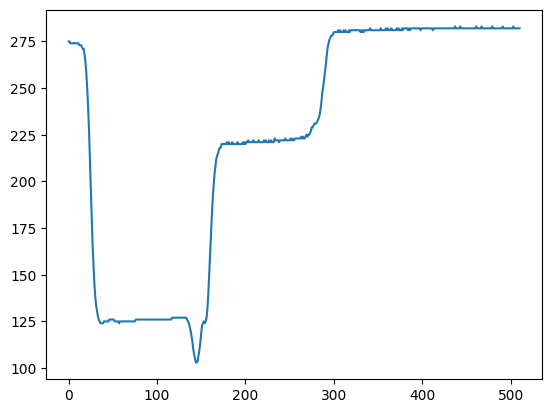

Finished 1 slice


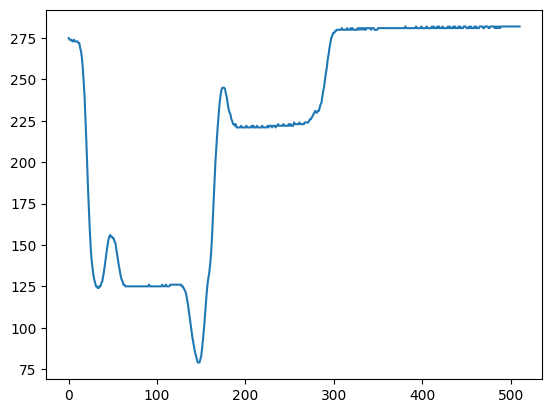

Finished 1 slice


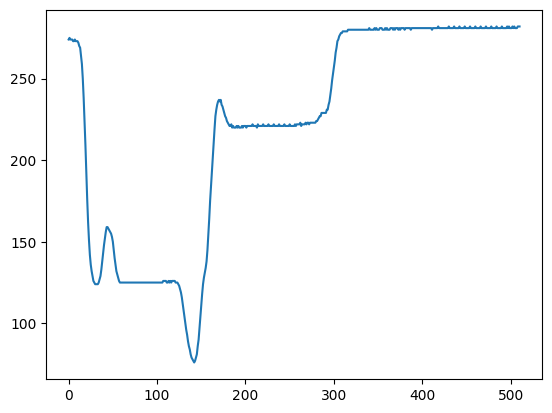

Finished 1 slice


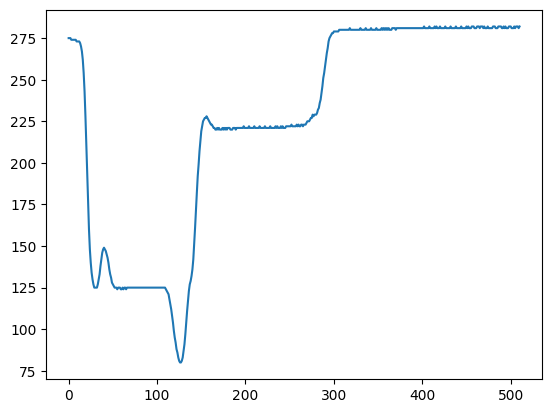

Finished 1 slice


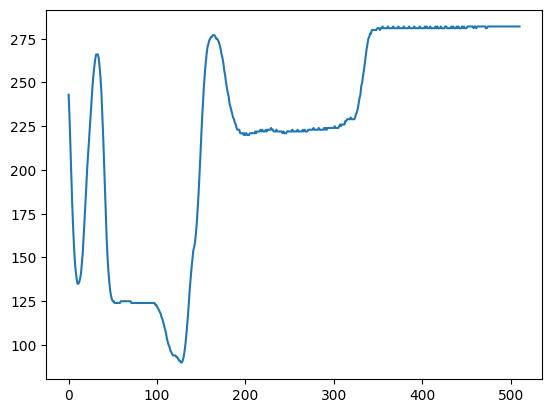

Finished 1 slice


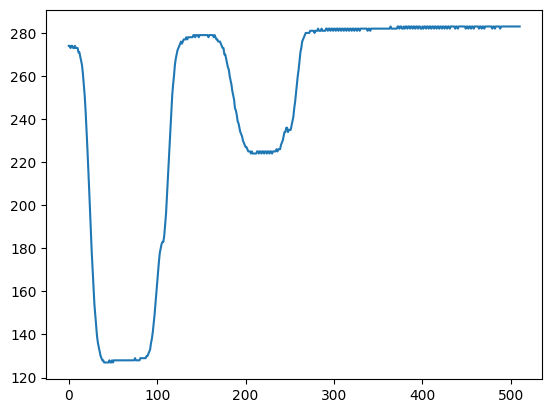

Finished 1 slice


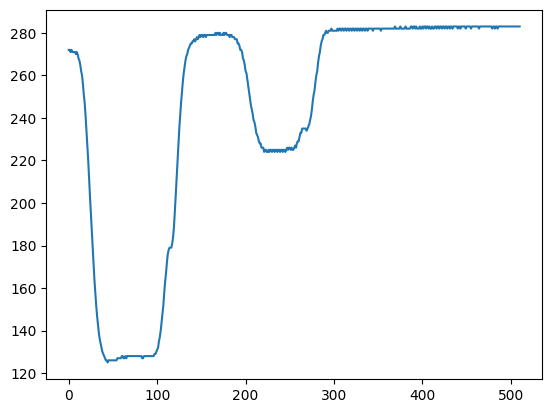

Finished 1 slice


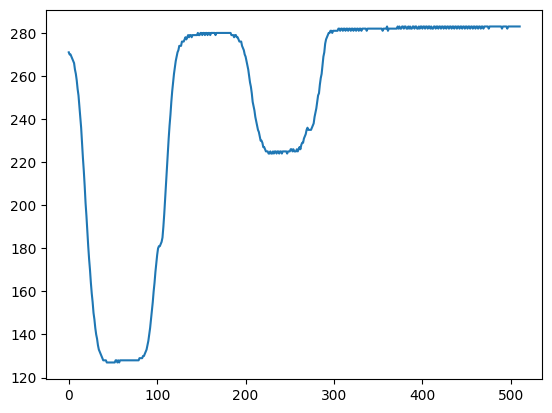

Finished 1 slice


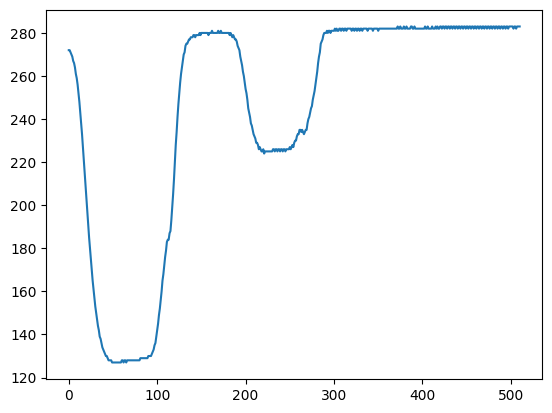

Finished 1 slice


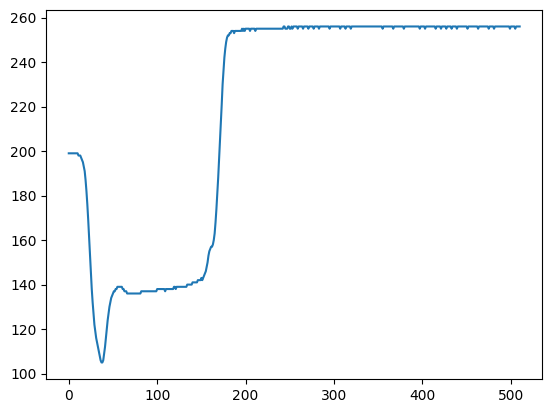

Finished 1 slice


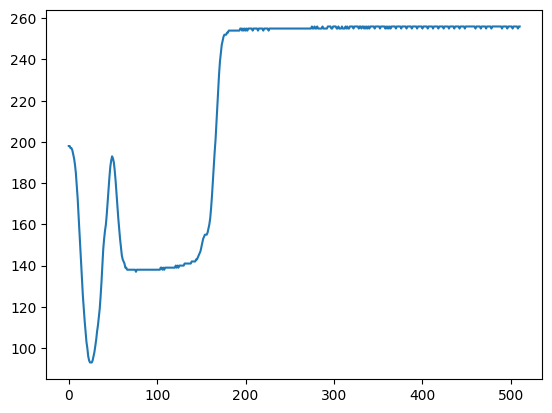

Finished 1 slice


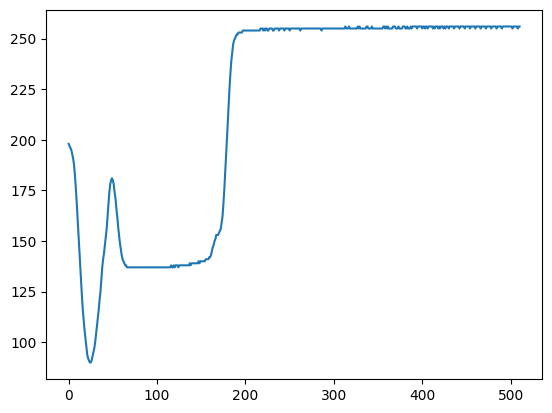

Finished 1 slice


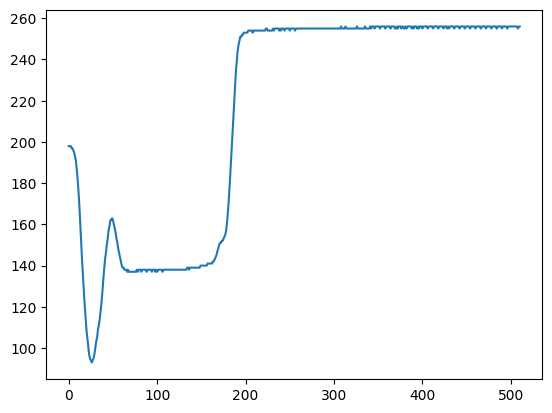

Finished 1 slice


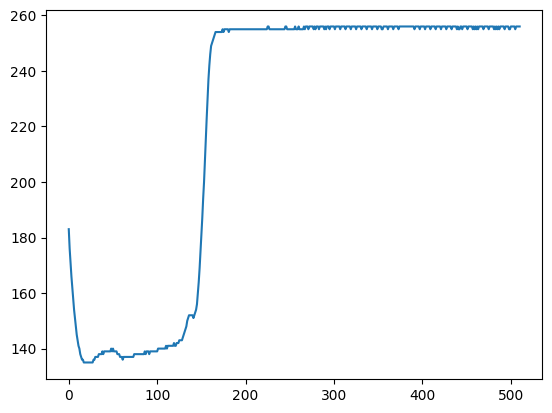

Finished 1 slice


In [34]:
# # During activity, keep reading Serial and add raw signal value into ringbuffer
# cell_1_flat_last5s = RingBuffer(2500)
# cell_1_flat_historyBuffer = RingBuffer(100)
# cell_1_flat_sliceArray = []

# cell_1_flat_busyReading = False
# cell_1_flat_avgMean = 0
# cell_1_flat_historyMean = 100000
# cell_1_flat_samplingStep = 0
# cell_1_flat_nrOfSlices = 0
# for sigVal in solar_cell_1_flat:
#     if (not cell_1_flat_busyReading):
#         # Add value to last 5s, to get average mean threshold
#         cell_1_flat_last5s.append(sigVal)
#         cell_1_flat_avgMean = np.mean(cell_1_flat_last5s.get())
#         # Keep history record of signal, such that we know what happened, when we trigger the condition for a slice.
#         cell_1_flat_historyBuffer.append(sigVal)
#         cell_1_flat_historyMean = np.mean(cell_1_flat_historyBuffer.get())
#     # Threshold determination part
#     if cell_1_flat_historyMean < 0.6*cell_1_flat_avgMean and cell_1_flat_samplingStep < 412:
#         cell_1_flat_busyReading = True
#         if(len(cell_1_flat_sliceArray)<1):
#             cell_1_flat_sliceArray = cell_1_flat_historyBuffer.get()
#         else:
#             cell_1_flat_sliceArray.append(sigVal)
#         cell_1_flat_samplingStep+= 1
#     elif (cell_1_flat_busyReading):
#         plt.plot(cell_1_flat_sliceArray)
#         plt.show()
#         # Reset every intermediate value
#         print("Finished 1 slice")
#         cell_1_flat_samplingStep = 0
#         cell_1_flat_busyReading = False
#         cell_1_flat_historyMean = 1000000
#         cell_1_flat_historyBuffer.clear()
#         cell_1_flat_sliceArray = []
#         cell_1_flat_nrOfSlices +=1


# cell_1_vertical_last5s = RingBuffer(2500)
# cell_1_vertical_historyBuffer = RingBuffer(100)
# cell_1_vertical_sliceArray = []

# cell_1_vertical_busyReading = False
# cell_1_vertical_avgMean = 0
# cell_1_vertical_historyMean = 100000
# cell_1_vertical_samplingStep = 0
# cell_1_vertical_nrOfSlices = 0
# for sigVal in solar_cell_1_vertical:
#     if (not cell_1_vertical_busyReading):
#         # Add value to last 5s, to get average mean threshold
#         cell_1_vertical_last5s.append(sigVal)
#         cell_1_vertical_avgMean = np.mean(cell_1_vertical_last5s.get())
#         # Keep history record of signal, such that we know what happened, when we trigger the condition for a slice.
#         cell_1_vertical_historyBuffer.append(sigVal)
#         cell_1_vertical_historyMean = np.mean(cell_1_vertical_historyBuffer.get())
#     # Threshold determination part
#     if cell_1_vertical_historyMean < 0.6*cell_1_vertical_avgMean and cell_1_flat_samplingStep < 412:
#         cell_1_vertical_busyReading = True
#         if(len(cell_1_vertical_sliceArray)<1):
#             cell_1_vertical_sliceArray = cell_1_vertical_historyBuffer.get()
#         else:
#             cell_1_vertical_sliceArray.append(sigVal)
#         cell_1_vertical_samplingStep+= 1
#     elif (cell_1_vertical_busyReading):
#         plt.plot(cell_1_vertical_sliceArray)
#         plt.show()
#         # Reset every intermediate value
#         print("Finished 1 slice")
#         cell_1_vertical_samplingStep = 0
#         cell_1_vertical_busyReading = False
#         cell_1_vertical_historyMean = 1000000
#         cell_1_vertical_historyBuffer.clear()
#         cell_1_vertical_sliceArray = []
#         cell_1_vertical_nrOfSlices +=1


# cell_2_flat_last5s = RingBuffer(2500)
# cell_2_flat_historyBuffer = RingBuffer(100)
# cell_2_flat_sliceArray = []

# cell_2_flat_busyReading = False
# cell_2_flat_avgMean = 0
# cell_2_flat_historyMean = 100000
# cell_2_flat_samplingStep = 0
# cell_2_flat_nrOfSlices = 0
# for sigVal in solar_cell_2_flat:
#     if (not cell_2_flat_busyReading):
#         # Add value to last 5s, to get average mean threshold
#         cell_2_flat_last5s.append(sigVal)
#         cell_2_flat_avgMean = np.mean(cell_2_flat_last5s.get())
#         # Keep history record of signal, such that we know what happened, when we trigger the condition for a slice.
#         cell_2_flat_historyBuffer.append(sigVal)
#         cell_2_flat_historyMean = np.mean(cell_2_flat_historyBuffer.get())
#     # Threshold determination part
#     if cell_2_flat_historyMean < 0.6*cell_2_flat_avgMean and cell_2_flat_samplingStep < 412:
#         cell_2_flat_busyReading = True
#         if(len(cell_2_flat_sliceArray)<1):
#             cell_2_flat_sliceArray = cell_2_flat_historyBuffer.get()
#         else:
#             cell_2_flat_sliceArray.append(sigVal)
#         cell_2_flat_samplingStep+= 1
#     elif (cell_2_flat_busyReading):
#         plt.plot(cell_2_flat_sliceArray)
#         plt.show()
#         # Reset every intermediate value
#         print("Finished 1 slice")
#         cell_2_flat_samplingStep = 0
#         cell_2_flat_busyReading = False
#         cell_2_flat_historyMean = 1000000
#         cell_2_flat_historyBuffer.clear()
#         cell_2_flat_sliceArray = []
#         cell_2_flat_nrOfSlices +=1


# cell_2_vertical_last5s = RingBuffer(2500)
# cell_2_vertical_historyBuffer = RingBuffer(100)
# cell_2_vertical_sliceArray = []

# cell_2_vertical_busyReading = False
# cell_2_vertical_avgMean = 0
# cell_2_vertical_historyMean = 100000
# cell_2_vertical_samplingStep = 0
# cell_2_vertical_nrOfSlices = 0
# for sigVal in solar_cell_2_vertical:
#     if (not cell_2_vertical_busyReading):
#         # Add value to last 5s, to get average mean threshold
#         cell_2_vertical_last5s.append(sigVal)
#         cell_2_vertical_avgMean = np.mean(cell_2_vertical_last5s.get())
#         # Keep history record of signal, such that we know what happened, when we trigger the condition for a slice.
#         cell_2_vertical_historyBuffer.append(sigVal)
#         cell_2_vertical_historyMean = np.mean(cell_2_vertical_historyBuffer.get())
#     # Threshold determination part
#     if cell_2_vertical_historyMean < 0.6*cell_2_vertical_avgMean and cell_2_flat_samplingStep < 412:
#         cell_2_vertical_busyReading = True
#         if(len(cell_2_vertical_sliceArray)<1):
#             cell_2_vertical_sliceArray = cell_2_vertical_historyBuffer.get()
#         else:
#             cell_2_vertical_sliceArray.append(sigVal)
#         cell_2_vertical_samplingStep+= 1
#     elif (cell_2_vertical_busyReading):
#         plt.plot(cell_2_vertical_sliceArray)
#         plt.show()
#         # Reset every intermediate value
#         print("Finished 1 slice")
#         cell_2_vertical_samplingStep = 0
#         cell_2_vertical_busyReading = False
#         cell_2_vertical_historyMean = 1000000
#         cell_2_vertical_historyBuffer.clear()
#         cell_2_vertical_sliceArray = []
#         cell_2_vertical_nrOfSlices +=1

# print("nr of slices:" + str(cell_1_flat_nrOfSlices))
# print("nr of slices:" + str(cell_1_vertical_nrOfSlices))
# print("nr of slices:" + str(cell_2_flat_nrOfSlices))
# print("nr of slices:" + str(cell_2_vertical_nrOfSlices))

class CellProcessor:
    def __init__(self):
        self.last5s = RingBuffer(2500)
        self.historyBuffer = RingBuffer(100)
        self.sliceArray = []
        self.busyReading = False
        self.avgMean = 0
        self.historyMean = 100000
        self.samplingStep = 0
        self.nrOfSlices = 0

    def process_signal(self, signal):
        for sigVal in signal:
            if (not self.busyReading):
                self.last5s.append(sigVal)
                self.avgMean = np.mean(self.last5s.get())
                self.historyBuffer.append(sigVal)
                self.historyMean = np.mean(self.historyBuffer.get())

            if self.historyMean < 0.6 * self.avgMean and self.samplingStep < 412:
                self.busyReading = True
                if not self.sliceArray:
                    self.sliceArray = self.historyBuffer.get()
                else:
                    self.sliceArray.append(sigVal)
                self.samplingStep += 1
            elif self.busyReading:
                plt.plot(self.sliceArray)
                plt.show()
                print("Finished 1 slice")
                self.samplingStep = 0
                self.busyReading = False
                self.historyMean = 1000000
                self.historyBuffer.clear()
                self.sliceArray = []
                self.nrOfSlices += 1

# Create the instance
processor_1_flat = CellProcessor()
processor_1_vertical = CellProcessor()
processor_2_flat = CellProcessor()
processor_2_vertical = CellProcessor()

# process the signal
processor_1_flat.process_signal(solar_cell_1_flat)
processor_1_vertical.process_signal(solar_cell_1_vertical)
processor_2_flat.process_signal(solar_cell_2_flat)
processor_2_vertical.process_signal(solar_cell_2_vertical)



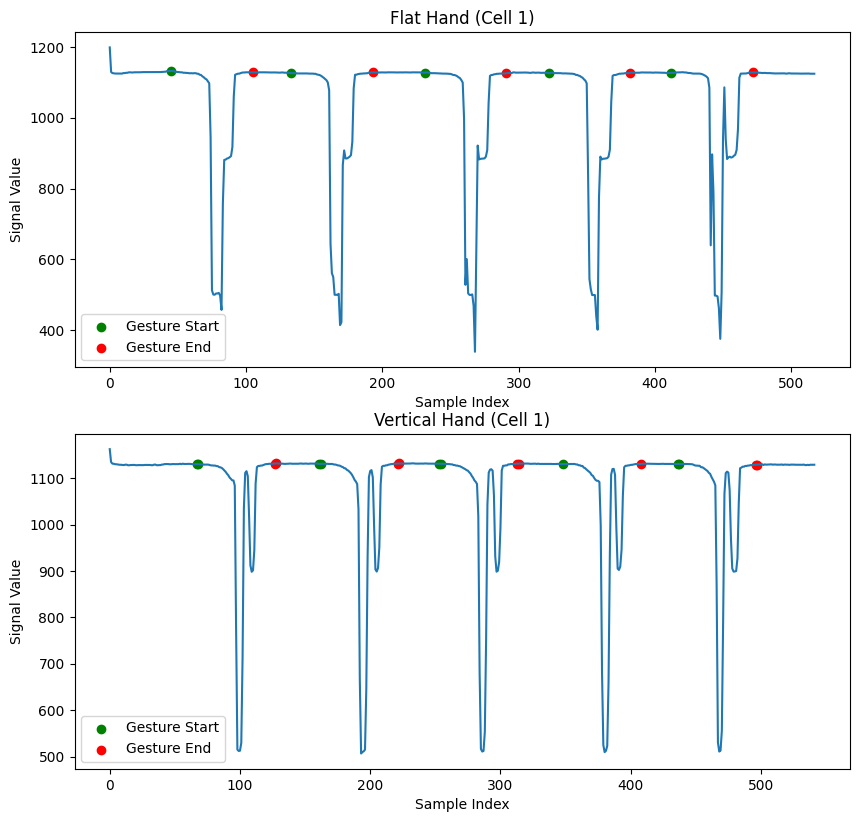

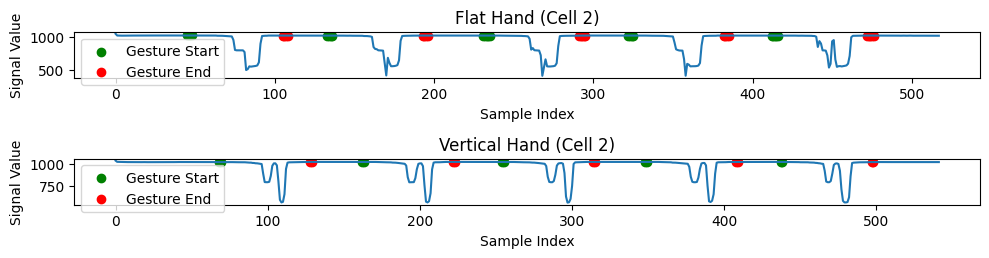

In [41]:
def detect_gesture_starts_ends(signal, window_size, std_threshold, mean_threshold):
    starts = []
    ends = []

    for i in range(len(signal) - window_size):
        window = signal[i:i+window_size]
        std_dev = np.std(window)
        mean = np.mean(window)
        last_sample = window[-1]

        if std_dev < std_threshold and abs(last_sample - mean) > mean_threshold:
            starts.append(i)
            ends.append(i + 2*window_size)

    return starts, ends

# Get the start and end points of hand gesture of cell 1
zscore_solar_cell_1_flat = stats.zscore(solar_cell_denoised_1_flat)
zscore_solar_cell_1_vertical = stats.zscore(solar_cell_denoised_1_vertical)
starts_1_flat, ends_1_flat = detect_gesture_starts_ends(zscore_solar_cell_1_flat, 30, 0.5, 0.45) #the mean and std threshold should be changed?????????
starts_1_vertical, ends_1_vertical = detect_gesture_starts_ends(zscore_solar_cell_1_vertical, 30, 0.5, 0.25)

# Get the start and end points of hand gesture of cell 2
zscore_solar_cell_2_flat = stats.zscore(solar_cell_denoised_2_flat)
zscore_solar_cell_2_vertical = stats.zscore(solar_cell_denoised_2_vertical)
starts_2_flat, ends_2_flat = detect_gesture_starts_ends(zscore_solar_cell_2_flat, 30, 0.5, 0.25) #the mean and std threshold should be changed?????????
starts_2_vertical, ends_2_vertical = detect_gesture_starts_ends(zscore_solar_cell_2_vertical, 30, 0.5, 0.25)

## Plot the flat hand gesture of cell 1 signals
plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)  # Create a subplot with 2 rows and 1 column, select the first subplot
plt.plot(solar_cell_denoised_1_flat)
plt.title('Flat Hand (Cell 1)')

## Highlight the start and end points
plt.scatter(starts_1_flat, solar_cell_denoised_1_flat[starts_1_flat], color='green', label='Gesture Start')
plt.scatter(ends_1_flat, solar_cell_denoised_1_flat[ends_1_flat], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

## Plot the vertical hand gesture of cell 1 signals
plt.subplot(4, 1, 2)  # Select the second subplot
plt.plot(solar_cell_denoised_1_vertical)
plt.title('Vertical Hand (Cell 1)')

## Highlight the start and end points
plt.scatter(starts_1_vertical, solar_cell_denoised_1_vertical[starts_1_vertical], color='green', label='Gesture Start')
plt.scatter(ends_1_vertical, solar_cell_denoised_1_vertical[ends_1_vertical], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

## Plot the flat hand gesture of cell 2 signals
plt.figure(figsize=(10, 5))
plt.subplot(4, 1, 3)  # Create a subplot with 2 rows and 1 column, select the first subplot
plt.plot(solar_cell_denoised_2_flat)
plt.title('Flat Hand (Cell 2)')

## Highlight the start and end points
plt.scatter(starts_2_flat, solar_cell_denoised_2_flat[starts_2_flat], color='green', label='Gesture Start')
plt.scatter(ends_2_flat, solar_cell_denoised_2_flat[ends_2_flat], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

## Plot the vertical hand gesture of cell 1 signals
plt.subplot(4, 1, 4)  # Select the second subplot
plt.plot(solar_cell_denoised_2_vertical)
plt.title('Vertical Hand (Cell 2)')

## Highlight the start and end points
plt.scatter(starts_2_vertical, solar_cell_denoised_2_vertical[starts_2_vertical], color='green', label='Gesture Start')
plt.scatter(ends_2_vertical, solar_cell_denoised_2_vertical[ends_2_vertical], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

## Get the features of different gestures

In [42]:
def interpolate_signal(signal, target_length=512):
    original_time = np.linspace(0, 1, len(signal))
    interpolator = interp1d(original_time, signal, kind='linear')
    upscaled_time = np.linspace(0, 1, target_length)
    return interpolator(upscaled_time)

def extract_features_from_slice(slice):
    coeffs = pywt.wavedec(slice, 'haar', level=5)
    std_dev = statistics.stdev(coeffs[1])
    mean_val = np.mean(coeffs[1])
    min_val = np.min(coeffs[1])
    max_val = np.max(coeffs[1])
    difference = max_val - min_val
    return std_dev, mean_val, min_val, max_val, difference

def process_solar_cell(solar_cell, starts, ends):
    features = {
        'std_dev': [],
        'mean_val': [],
        'min_val': [],
        'max_val': [],
        'difference': []
    }

    for start, end in zip(starts, ends):
        slice = solar_cell[start:end+1]
        interpolated_slice = interpolate_signal(slice)
        std_dev, mean_val, min_val, max_val, difference = extract_features_from_slice(interpolated_slice)

        features['std_dev'].append(std_dev)
        features['mean_val'].append(mean_val)
        features['min_val'].append(min_val)
        features['max_val'].append(max_val)
        features['difference'].append(difference)

    return features

# Process of cell 1
features_solar_1_flat = process_solar_cell(solar_cell_1_flat, starts_1_flat, ends_1_flat)
features_solar_1_vertical = process_solar_cell(solar_cell_1_vertical, starts_1_vertical, ends_1_vertical)

# Process of cell 2
features_solar_2_flat = process_solar_cell(solar_cell_2_flat, starts_2_flat, ends_2_flat)
features_solar_2_vertical = process_solar_cell(solar_cell_2_vertical, starts_2_vertical, ends_2_vertical)

# Output
print("Flat Hand cell 1")
print(features_solar_1_flat)
print("Vertical Hand cell 1")
print(features_solar_1_vertical)
print("Flat Hand cell 2")
print(features_solar_2_flat)
print("Vertical Hand cell 2")
print(features_solar_2_vertical)


Flat Hand cell 1
{'std_dev': [0.9282522571213506, 1.1801522948800722, 0.23732079037548998, 0.8295678974687467, 0.9149177309722577], 'mean_val': [0.10542602327131334, 0.22953294976388605, 0.06836691664969408, 0.15219314557154462, -0.09407477999457114], 'min_val': [-1.4654130749050864, -2.2046925227502925, -0.1750469820354965, -1.4941263150413988, -1.4941263150413988], 'max_val': [1.4654130749050864, 2.156952436740653, 0.8392568743435049, 1.3515979423168574, 1.3391440068360225], 'difference': [2.930826149810173, 4.361644959490945, 1.0143038563790014, 2.845724257358256, 2.8332703218774213]}
Vertical Hand cell 1
{'std_dev': [1.0965981852103324, 1.0907434472735549, 0.8499225504058607, 0.6070293877578083, 0.7484808154047506, 0.9697244484069599, 0.701320310439545, 1.0709295519061364, 1.1916667312890037], 'mean_val': [-0.16155521859791122, 0.24447334805763887, 0.2273708081873025, -0.24043014330947443, -0.06732908869298626, -0.11199893366395486, 0.0899667109991853, 0.22974916392146838, -0.21619

## Train the KNN model

In [43]:
X_train_flat_1 = np.column_stack((features_solar_1_flat['min_val'],features_solar_1_flat['max_val'], features_solar_1_flat['mean_val']))
X_train_vertical_1 = np.column_stack((features_solar_1_vertical['min_val'], features_solar_1_vertical['max_val'], features_solar_1_vertical['mean_val']))
X_train_1 = np.concatenate((X_train_flat_1, X_train_vertical_1), axis=0)

Y_train_1 = ["flat", "flat", "flat", "flat", "flat", "vertical", "vertical", "vertical", "vertical", "vertical"]
knn_model_1 = KNeighborsClassifier(n_neighbors=3)  
knn_model_1.fit(X_train_1, Y_train_1)  # train the model

X_train_flat_2 = np.column_stack((features_solar_2_flat['min_val'],features_solar_2_flat['max_val'], features_solar_2_flat['mean_val']))
X_train_vertical_2 = np.column_stack((features_solar_2_vertical['min_val'], features_solar_2_vertical['max_val'], features_solar_2_vertical['mean_val']))
X_train_1 = np.concatenate((X_train_flat_2, X_train_vertical_2), axis=0)

Y_train_2 = ["flat", "flat", "flat", "flat", "flat", "vertical", "vertical", "vertical", "vertical", "vertical"]
knn_model_2 = KNeighborsClassifier(n_neighbors=3)  
knn_model_2.fit(X_train_2, Y_train_2)  # train the model

fig_2 = plt.figure(figsize=(10, 8))
ax_2 = fig_2.add_subplot(projection='3d')

# Feature Extraction
min_2_flat, std_2_flat, mean_2_flat = X_train_flat_2[:, 0], X_train_flat_2[:, 1], X_train_flat_2[:, 2]
min_2_vertical, std_2_vertical, mean_2_vertical = X_train_vertical_2[:, 0], X_train_vertical_2[:, 1], X_train_vertical_2[:, 2]

# Plot the figure
ax_2.scatter(min_2_flat, std_2_flat, mean_2_flat, c='r', label='Flat Gestures')
ax_2.scatter(min_2_vertical, std_2_vertical, mean_2_vertical, c='b', label='Vertical Gestures')

# Add axises labels
ax_2.set_xlabel('Min')
ax_2.set_ylabel('Max')
ax_2.set_zlabel('Mean')

ax_2.legend()

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [14, 10]

In [ ]:
ser = serial.Serial('COM3', 115200) 

try:
    while True:
        data = ser.readline().decode('utf-8').strip()
        if data:
            predicted_gesture = knn_model.predict([data_vector])

            print(f'Predicted Gesture: {predicted_gesture}')

except KeyboardInterrupt:
    pass
finally:
   
    ser.close()